In [74]:
import os
import pandas as pd
import json
import  matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import shape

In [75]:
os.getcwd()

'/Users/mazeppa/Desktop/Springboard/Capstone1/3:Analysis'

### 1/  Importing geographical data for the locations of all traffic records

In [76]:
#For mapbox API
mapbox_token="pk.eyJ1IjoibWF6ZXBwIiwiYSI6ImNrYmdudnlhbDBsMm4ycm1sdnAzY3RvN2IifQ.MKMZZ8WP8JJ1CCcUOv0XGw" #for the mapas layou

In [77]:
#load geolocalization data
geo=pd.read_csv("/Users/mazeppa/Desktop/Springboard/Capstone1/3:Analysis/Data/paris_geo.csv",sep=";")

#Rename Columns for merge
to_rename={"Identifiant arc":"location_ID","Libelle":"road_name"}
geo=geo.rename(columns=to_rename)

#Split coordinates into long and lat
geo[["latitude","longitude"]]=geo.geo_point_2d.str.split(",",expand=True)

#Add categorical
geo["road_name"] = pd.Categorical(geo["road_name"])
geo['road_ID'] = geo["road_name"].cat.codes

#keep only columns of interest and set the location ID to index
geo=geo[["location_ID","road_ID","road_name","latitude","longitude"]].set_index("location_ID")

#Correct columns types and sort by latitude iu_ac and latitude
geo=geo.astype({'longitude': 'float64','latitude': 'float64'}).sort_values(by=["location_ID","latitude"])

geo.head()

,road_ID,road_name,latitude,longitude
location_ID,,,,
1,781,Quai_du_Louvre,48.859838,2.334242
2,781,Quai_du_Louvre,48.859375,2.336451
3,781,Quai_du_Louvre,48.859019,2.339782
3,781,Quai_du_Louvre,48.859134,2.338776
4,781,Quai_du_Louvre,48.858479,2.342476


In [78]:
#The location of the sensors is identified by a location key.
#We need to ensure that to each key corresponds exactly one pair of coordinates
print("the number of location keys corresponding to multiple locations is : ",(geo.groupby("location_ID").size()>1).sum())

the number of location keys corresponding to multiple locations is :  338


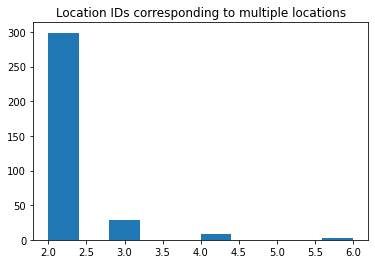

In [79]:
#The location of the sensors is identified by a location key.
#We need to ensure that to each key corresponds exactly one pair of coordinates
mask=(geo.groupby("location_ID").size()>1)
mask=list(mask[mask].index)

#Check the number of duplicate IDs for location
duplicates=geo.loc[mask].reset_index()
plt.hist(duplicates.groupby("location_ID").size());
plt.title("Location IDs corresponding to multiple locations");

In [80]:
#Let us vizualize the locations of the duplicates

import plotly.graph_objects as go


# Create figure
fig = go.Figure()


fig.add_trace(
        
          (go.Scattermapbox(
        lon = duplicates["longitude"],
        lat = duplicates["latitude"],
        mode = 'markers',
        text=duplicates["location_ID"]
          )))
        
fig.update_layout(
    showlegend = False,
    mapbox = {
        'accesstoken' : mapbox_token,
        'center': {'lon': 2.3522, 'lat': 48.8566},
        'zoom': 10})


fig.show()

In [81]:
geo.head()

,road_ID,road_name,latitude,longitude
location_ID,,,,
1,781,Quai_du_Louvre,48.859838,2.334242
2,781,Quai_du_Louvre,48.859375,2.336451
3,781,Quai_du_Louvre,48.859019,2.339782
3,781,Quai_du_Louvre,48.859134,2.338776
4,781,Quai_du_Louvre,48.858479,2.342476


In [82]:
#The graph above shows that the duplicates correspond to either beginnings or ends of road segments. 
#Therefore we can randomly assign one of the duplicate coordinates to each location ID
geo=pd.merge(geo.groupby("location_ID")[["latitude"]].max().reset_index(),geo,how="left",on=["latitude"])
geo=geo[["location_ID","road_ID","road_name","latitude","longitude"]]
print("the number of location keys corresponding to multiple locations is : ",(geo.groupby("location_ID").size()>1).sum())

the number of location keys corresponding to multiple locations is :  0


In [83]:
geo.head()

,location_ID,road_ID,road_name,latitude,longitude
0,1,781,Quai_du_Louvre,48.859838,2.334242
1,2,781,Quai_du_Louvre,48.859375,2.336451
2,3,781,Quai_du_Louvre,48.859134,2.338776
3,4,781,Quai_du_Louvre,48.858747,2.341134
4,5,776,Quai_de_la_Megisserie,48.858214,2.343447


### 2/ Creating a base table to receive existing records

In [84]:
#The traffic records are taken on an hourly basis.
#For the sake of time series analysis, we need a record at each station for every hour over the entire duration

#Let us create an hourly time table
dates=pd.date_range(start='2016-01-01', end='2017-01-01', freq='H')[1:8785]
dates=pd.DataFrame({"timestamp":dates})

#Now we merge this time table with the location table
dates["tmp"]=1
geo["tmp"]=1
base_table=pd.merge(dates,geo,on="tmp").drop(["tmp"],axis=1)

In [85]:
base_table.head()

,timestamp,location_ID,road_ID,road_name,latitude,longitude
0,2016-01-01 01:00:00,1,781,Quai_du_Louvre,48.859838,2.334242
1,2016-01-01 01:00:00,2,781,Quai_du_Louvre,48.859375,2.336451
2,2016-01-01 01:00:00,3,781,Quai_du_Louvre,48.859134,2.338776
3,2016-01-01 01:00:00,4,781,Quai_du_Louvre,48.858747,2.341134
4,2016-01-01 01:00:00,5,776,Quai_de_la_Megisserie,48.858214,2.343447


In [86]:
base_table.shape

(29408832, 6)

### 3/ Importing Traffic Records

In [ ]:
import glob

dfs=[]

# get data file names
path =r'/Users/mazeppa/Desktop/Springboard/Capstone1/3:Analysis/Data/Paris_Traffic_2016'
filenames = glob.glob(path + "/*.csv")

for filename in filenames:
    dfs.append(pd.read_csv(filename,sep=";"))

In [ ]:
# Concatenate all data into one DataFrame
df = pd.concat(dfs, ignore_index=True)

In [ ]:
df.head(5)

In [ ]:
#Correct column types
df["t_1h"]=pd.to_datetime(df["t_1h"])

#Rename Columns
to_rename={"t_1h":"timestamp", "iu_ac": "location_ID","etat_barre": "road_status", "etat_trafic":"trafic_status","q": "flow_rate","k": "occupation_rate"}
df=df.rename(columns=to_rename)

#Drop unnecessary columns
df=df[list(to_rename.values())]

In [ ]:
df.head(5)

In [ ]:
#Merge dataframes
df=pd.merge(base_table,df,how="left",on=["timestamp","location_ID"])

In [ ]:
df.shape

In [ ]:
df.head()

### 3/ Creating new features

In [ ]:
#Add columns for year, month, dayof year, weekday, and hour
df["date"]=df["timestamp"].apply(lambda x : x.date())
#df["weekday"]=df["timestamp"].apply(lambda x : x.weekday())
#df["hour"]=df["timestamp"].apply(lambda x : x.hour)

In [ ]:
#Reorder columns
columns=["timestamp","date","weekday","hour","location_ID", "road_ID","road_name","longitude","latitude","road_status","trafic_status","flow_rate","occupation_rate"]
df=df[columns]

#Sort values by date
df=df.sort_values(by="timestamp")

df.head()

### 4/ Cleaning missing records

In [ ]:
#Now, let us check for locations with no or few records

records_by_location=df.groupby("location_ID").count()["occupation_rate"].reset_index(name="counts")

fig=go.Figure()
fig.add_trace(go.Histogram(x=records_by_location["counts"], marker_color='indianred'))
fig.show()

In [ ]:
#The above chart shows us that many locations don't have any records at all or not enough records
#Let us keep only locations with at least 95% of the records
df=df[df["location_ID"].isin(list(records_by_location[records_by_location["counts"] > 8345]["location_ID"]))]

In [ ]:
df.shape

In [ ]:
df.isna().sum()

In [ ]:
# Let us plot the distribution of the number of records once more
records_by_location=df.groupby("location_ID").count()["occupation_rate"].reset_index(name="counts")

fig=go.Figure()
fig.add_trace(go.Histogram(x=records_by_location["counts"], marker_color='indianred'))
fig.show()

In [ ]:
#Let us vizualize the number of missing records each day
missing=(df.groupby("date").size()-df.groupby("date").count()['occupation_rate']).reset_index(name="counts")

#Figure
fig=go.Figure()
fig.add_trace(go.Bar(x=missing["date"],y=missing["counts"]))
fig.update_layout(barmode='stack')
fig.show()

### 5/ Cleaning Zero Values

In [ ]:
#Occupation rate mean distribution
plt.hist(df.groupby("location_ID")["occupation_rate"].mean(),bins=40);

In [ ]:
#Create pivot dataframe with occupation rate values only
occupation_df=df.set_index("location_ID")[["timestamp","occupation_rate"]].pivot(columns="timestamp",values="occupation_rate")

#Plot number of Zero values for each location ID
plt.plot(pd.DataFrame((occupation_df==0).sum(axis=1)))

In [ ]:
#Search for location IDs with only Null values
occupation_zero=(occupation_df==0).sum(axis=1) 
occupation_zero=occupation_zero[occupation_zero > 8000].index

#Drop those location IDs
df=df[np.isin(df["location_ID"],occupation_zero,invert=True)]

#Create pivot dataframe with occupation rate values only
occupation_df=df.set_index("location_ID")[["timestamp","occupation_rate"]].pivot(columns="timestamp",values="occupation_rate")

#Plot number of Zero values for each location ID
plt.plot(pd.DataFrame((occupation_df==0).sum(axis=1)));

In [ ]:
df.shape

### 6/ Dealing with duplicates

In [ ]:
## All we need to do to check for duplicates is to compute the average traffic 
##rate over the entire year at each location and compare the values

In [ ]:
#Find number of duplicates 
occupation_mean[["location_ID","occupation_rate"]].set_index("location_ID").duplicated(keep="last").sum()

In [ ]:
#Find location IDs of duplicates
mask=occupation_mean[["location_ID","occupation_rate"]].set_index("location_ID").duplicated()
mask=mask[mask].index

#Create duplicate table
duplicates=geo.set_index("location_ID").loc[mask].reset_index()

#Show duplicates on map
fig = go.Figure()

fig.add_trace(
        
          (go.Scattermapbox(
        lon = duplicates["longitude"],
        lat = duplicates["latitude"],
        mode = 'markers',
        text=duplicates["location_ID"]
          )))
        
fig.update_layout(
    showlegend = False,
    mapbox = {
        'accesstoken' : mapbox_token,
        'center': {'lon': 2.3522, 'lat': 48.8566},
        'zoom': 10})


fig.show()

In [ ]:
#Drop the duplicates
mask=~occupation_mean[["location_ID","occupation_rate"]].set_index("location_ID").duplicated(keep="first")
df=df.set_index("location_ID").loc(mask)

In [ ]:
df.shape

### 5/ Saving DataFrames

In [ ]:
#save df to csv
df.to_csv("paris_traffic_clean.csv",index=False)

In [ ]:
df.head()

In [ ]:
#Create pivot dataframe with occupation rate values only
occupation_df=df.set_index("timestamp")[["location_ID","occupation_rate"]].pivot(columns="location_ID",values="occupation_rate")

#Save occupation_df to csv 
occupation_df.to_csv("paris_traffic_clean.csv",index=False)